[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/seap-udea/multimin/blob/master/examples/multimin_asteroids_application.ipynb)

<p align="left"><img src="https://raw.githubusercontent.com/seap-udea/multimin/master/docs/multimin-logo-white.webp" width="600" /></p>

# Asteroid orbital elements: an application of **multimin**

This notebook goes deeper into the **multimin** module: loading data, building CMNDs, and fitting with bounds and multiple components for a particular case, the orbital elements of asteroids.

## Installation

If you're running this in Google Colab or need to install the package, uncomment and run the following cell:

In [1]:
import os
import matplotlib.pyplot as plt
os.makedirs('gallery', exist_ok=True)
try:
    from google.colab import drive
    %pip install -Uq multimin
except ImportError:
    print("Not running in Colab, skipping installation")
    %load_ext autoreload
    %autoreload 2
!mkdir -p gallery/

# Uncomment to install from GitHub (development version)
# !pip install git+https://github.com/seap-udea/MultiMin.git

Not running in Colab, skipping installation


## Load the package

Import **multimin** and other required libraries:

In [2]:
import pandas as pd
import numpy as np
import multimin as mn
import warnings
%matplotlib inline

warnings.filterwarnings("ignore")

figprefix="asteroids"

Welcome to MultiMin v0.9.5. ¡Al infinito y más allá!


## Asteroid data

**multimin** was originally developed to solve the problem of describing the distribution of asteroids in the space of orbital elements. This is a true scientific application of the package that illustrate the power of the methods and the versatility of the numerical methods provided by the package.

Load the dataset (e.g. orbital elements):

In [3]:
# NEA Data
df_neas=pd.read_json(mn.Util.get_data("nea_data.json.gz"))

# Let's filter 10000 asteroids
df_neas=df_neas.sample(10000)

# Let's select the columns we want to fit
df_neas["q"]=df_neas["a"]*(1-df_neas["e"])
data_neas=np.array(df_neas[["q","e","i","Node","Peri","M"]])

Let's see the data:

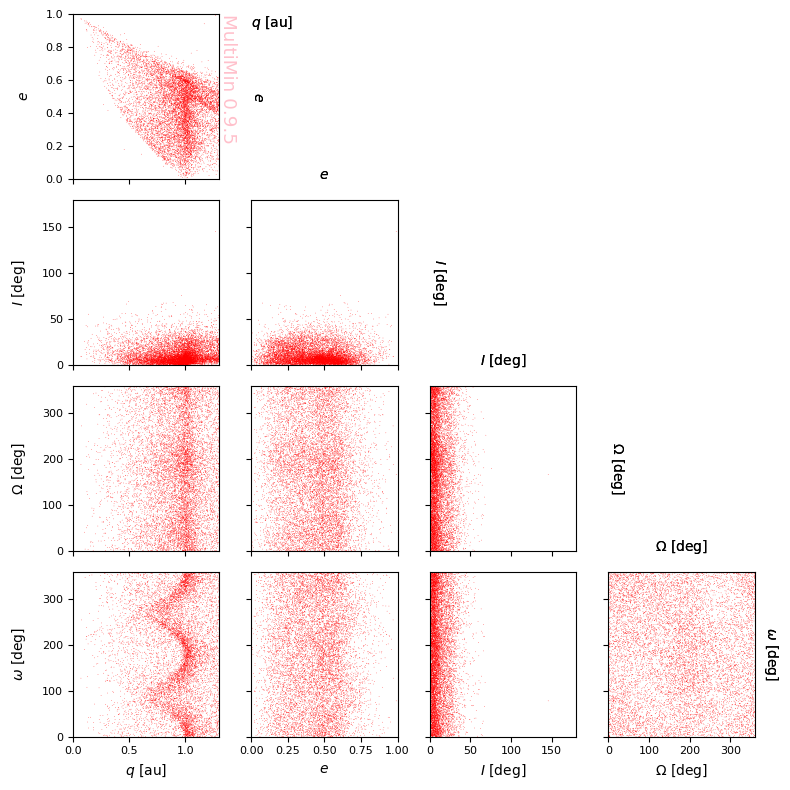

In [4]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
    i=dict(label=r"$I$ [deg]",range=[0.0,180.0]),
    W=dict(label=r"$\Omega$ [deg]",range=[0,360]),
    w=dict(label=r"$\omega$ [deg]",range=[0,360]),
)
G=mn.DensityPlot(properties,figsize=2)

sargs=dict(s=0.2,edgecolor='None',color='r')
scatter=G.scatter_plot(data_neas,**sargs)

plt.savefig(f'gallery/{figprefix}_data_neas.png')


Or a colormesh:

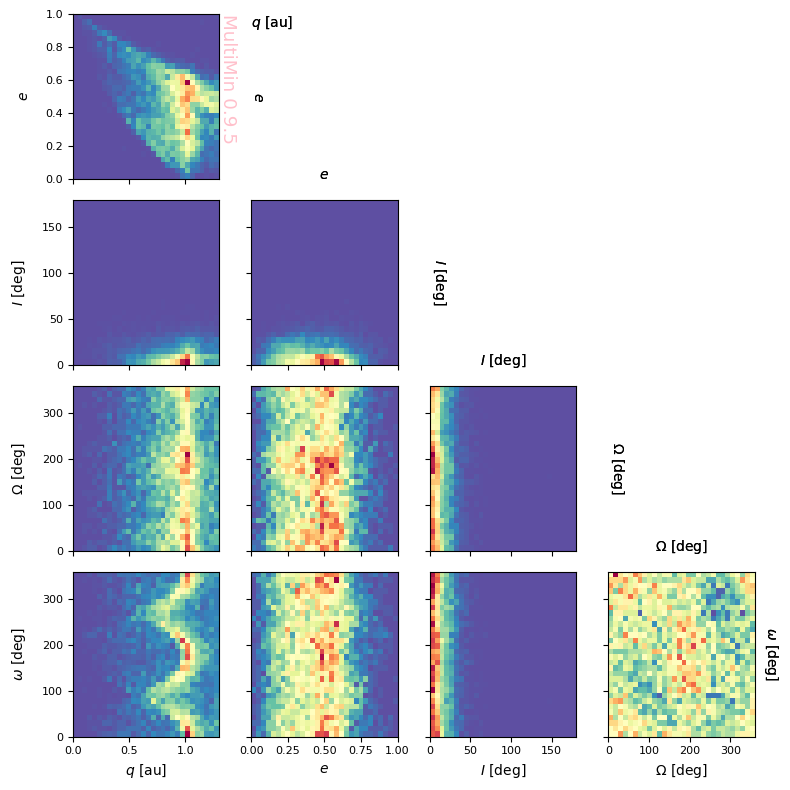

In [5]:
G=mn.DensityPlot(properties,figsize=2)
hargs=dict(bins=30,cmap='Spectral_r')
hist=G.plot_hist(data_neas,**hargs)
plt.savefig(f'gallery/{figprefix}_data_neas_hist.png')

### Non-trivially correlated properties

The only elements with a non-trivial distribution are $q, e, I$. Let's study the distribution, for instance, of the $q$ and $e$. For this purpose we need to create a subset:

In [6]:
data_neas_qe=np.array(df_neas[["q","e"]])

And plot it:

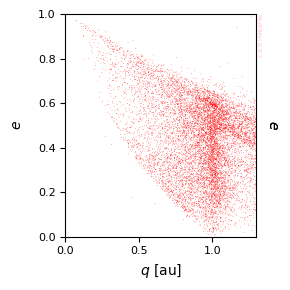

In [7]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)

G=mn.DensityPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
scatter=G.scatter_plot(data_neas_qe,**sargs)

plt.savefig(f'gallery/{figprefix}_data_neas_qe.png')

Now we will proceed to fit the data against a singled truncated distribution:

In [8]:
t = mn.Util.el_time(0)
F_qe_1 = mn.FitCMND(ngauss=1, nvars=2, domain=[[0,1.3], [0, 1]])
F_qe_1.fit_data(data_neas_qe, advance=0)
t = mn.Util.el_time()
print(f"-log(L)/N = {F_qe_1.solution.fun/len(data_neas_qe)}")

Elapsed time since last call: 146.13 ms
-log(L)/N = -0.5388859346739996


And check the fit result:

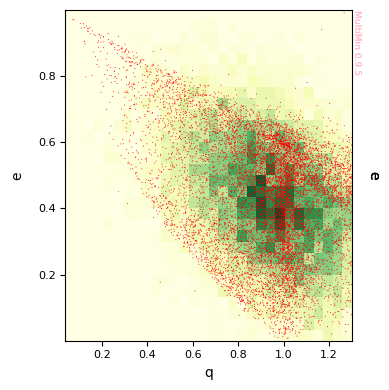

In [9]:
# properties: list of names or dict like DensityPlot (e.g. dict(q=dict(label=r"$q$", range=None), ...))
properties=["q","e"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F_qe_1.plot_fit(properties=properties,hargs=hargs,sargs=sargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_qe_1gauss.png')


In [10]:
F_qe_1.cmnd.tabulate()

,w,mu_1,mu_2,sigma_1,sigma_2,rho_12
component,,,,,,
1,1.0,0.96404,0.416035,0.26289,0.188537,-0.423887


We can do it better increasing the number of normals:

In [11]:
t = mn.Util.el_time(0)
F = mn.FitCMND(ngauss=5, nvars=2, domain=[[0,1.3], [0, 1]])
F.fit_data(data_neas_qe)
t = mn.Util.el_time()
print(f"-log(L)/N = {F.solution.fun/len(data_neas_qe)}")

Elapsed time since last call: 19.555 s
-log(L)/N = -0.7238499983627922


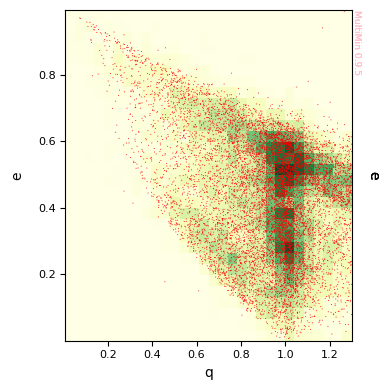

In [12]:
properties=["q","e"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F.plot_fit(
    properties=properties,
    hargs=hargs,
    sargs=sargs,
    figsize=4
)
plt.savefig(f'gallery/{figprefix}_fit_result_qe_5gauss.png')

Another way of comparing is to generate a sample with the fitted distribution and compare it with the original one:

In [13]:
neas_sample = F.cmnd.rvs(len(data_neas_qe))

And plot it:

Text(0.5, 1.0, 'Original data')

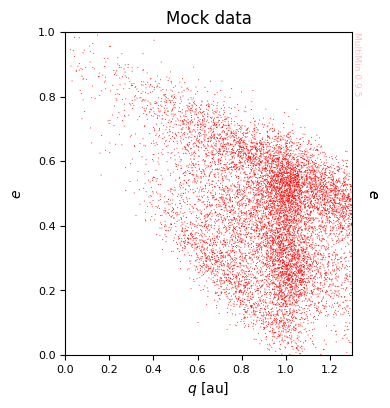

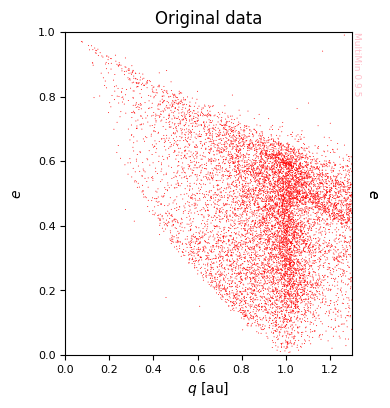

In [14]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
# Mock data
G = mn.DensityPlot(properties,figsize=4)
G.scatter_plot(neas_sample,**sargs)
G.axs[0][0].set_title("Mock data")
plt.savefig(f'gallery/{figprefix}_fit_result_qe_5gauss_sample.png')
# True data
G=mn.DensityPlot(properties,figsize=4)
scatter=G.scatter_plot(data_neas_qe,**sargs)
G.axs[0][0].set_title("Original data")


Let's see the fit function:

In [15]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)
table = F.cmnd.tabulate(properties=properties)
table

,w,mu_q,mu_e,sigma_q,sigma_e,rho_qe
component,,,,,,
3,0.375828,0.923769,0.385571,0.246109,0.152372,-0.611480
4,0.289748,1.300000,0.461440,0.493019,0.183133,-0.955393
1,0.135625,1.007977,0.260940,0.054031,0.112896,-0.121568
5,0.105104,0.999615,0.517306,0.059994,0.074886,0.051188
2,0.093696,0.748094,0.230061,0.163501,0.116015,-0.909143


In [16]:
function, cmnd = F.cmnd.get_function(properties=properties)

import numpy as np
from multimin import tnmd

def cmnd(X):

    a = [0.0, 0.0]
    b = [1.3, 1.0]

    mu1_q = 1.007977
    mu1_e = 0.26094
    mu1 = [mu1_q, mu1_e]
    Sigma1 = [[0.002919, -0.000742], [-0.000742, 0.012746]]
    Z1 = 0.989592
    n1 = tnmd(X, mu1, Sigma1, a, b, Z=Z1)

    mu2_q = 0.748094
    mu2_e = 0.230061
    mu2 = [mu2_q, mu2_e]
    Sigma2 = [[0.026733, -0.017245], [-0.017245, 0.01346]]
    Z2 = 0.976315
    n2 = tnmd(X, mu2, Sigma2, a, b, Z=Z2)

    mu3_q = 0.923769
    mu3_e = 0.385571
    mu3 = [mu3_q, mu3_e]
    Sigma3 = [[0.06057, -0.022931], [-0.022931, 0.023217]]
    Z3 = 0.93446
    n3 = tnmd(X, mu3, Sigma3, a, b, Z=Z3)

    mu4_q = 1.3
    mu4_e = 0.46144
    mu4 = [mu4_q, mu4_e]
    Sigma4 = [[0.243068, -0.086261], [-0.086261, 0.033538]]
    Z4 = 0.495629
    n4 = tnmd(X, mu4, Sigma4, a, b, Z=Z4)

    mu5_q = 0.999615
    mu5_e = 0.517306
    mu5 = [mu5_q, mu5_e]
    Sigma5 = [[0.003599, 0.00023], [0.00023, 0.005608]]
    Z5 = 1.0
    n5 = tnmd(X, mu5, S

### Fitting other pair of properties

Fitting $q$ and $I$:

-log(L)/N = 3.455452497170177


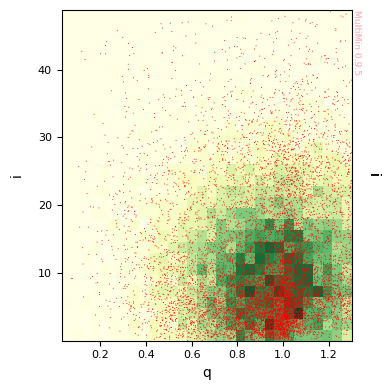

In [17]:
data_neas_qi=np.array(df_neas[["q","i"]])
F_qi_1 = mn.FitCMND(ngauss=1, nvars=2, domain=[[0,1.3], [0, 180]])
F_qi_1.fit_data(data_neas_qi, advance=0)
print(f"-log(L)/N = {F_qi_1.solution.fun/len(data_neas_qi)}")

properties=["q","i"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F_qi_1.plot_fit(properties=properties,hargs=hargs,sargs=sargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_qi_1gauss.png')

Fitting $e$ and $I$:

-log(L)/N = 3.2838709174545935


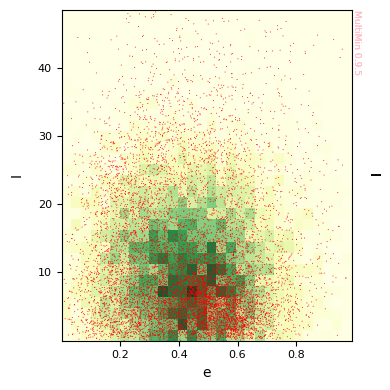

In [18]:
data_neas_ei=np.array(df_neas[["e","i"]])
F_ei_1 = mn.FitCMND(ngauss=1, nvars=2, domain=[[0,1], [0, 180]])
F_ei_1.fit_data(data_neas_ei, advance=0)
print(f"-log(L)/N = {F_ei_1.solution.fun/len(data_neas_ei)}")

properties=["e","I"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F_ei_1.plot_fit(properties=properties,hargs=hargs,sargs=sargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_ei_1gauss.png')

### Fitting three variables: $q, e, I$

Let's extract first the data:

In [19]:
data_neas_qei = np.array(df_neas[["q","e","i"]])

Let's plot the original data:

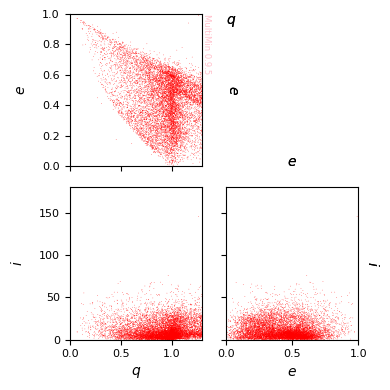

In [20]:
properties=dict(
    q=dict(label=r"$q$", range=[0.0, 1.3]),
    e=dict(label=r"$e$", range=[0.0, 1.0]),
    i=dict(label=r"$i$", range=[0.0, 180.0]),
)

G = mn.DensityPlot(properties, figsize=2)
sargs = dict(s=0.2, edgecolor='None', color='r')
scatter = G.scatter_plot(data_neas_qei, **sargs)
plt.savefig(f'gallery/{figprefix}_data_neas_qei.png')


Now let's try to fit this data using truncated multivariate distribution:

Iterations:
Iter 0:
	Vars: [0.38, 0.5, 0.0028, -2.5, -2.2, -7.5, 1, 1.1, 0.72]
	LogL/N: 690.2264202812323
Iter 1:
	Vars: [0.38, 0.5, 0.051, -2.5, -2.2, -7.5, 1, 1.1, 0.67]
	LogL/N: 689.9610412786712
Iter 2:
	Vars: [0.38, 0.5, 0.071, -2.5, -2.2, -7.5, 1, 1.1, 0.75]
	LogL/N: 689.8012131823855
Iter 3:
	Vars: [0.37, 0.49, 0.066, -2.5, -2.2, -7.5, 1, 1, 0.75]
	LogL/N: 689.841909367597
Iter 4:
	Vars: [0.37, 0.49, 0.058, -2.5, -2.2, -7.5, 1, 1, 0.76]
	LogL/N: 689.9069896193258
Iter 5:
	Vars: [0.37, 0.49, 0.059, -2.5, -2.2, -7.5, 1, 1, 0.76]
	LogL/N: 689.8958753537321
Iter 6:
	Vars: [0.37, 0.49, 0.063, -2.5, -2.2, -7.5, 1, 1, 0.75]
	LogL/N: 689.8626782887807
Iter 7:
	Vars: [0.37, 0.49, 0.063, -2.5, -2.2, -7.5, 1, 1, 0.75]
	LogL/N: 689.8626767059127
Iter 8:
	Vars: [0.37, 0.49, 0.063, -2.5, -2.2, -7.5, 1, 1, 0.75]
	LogL/N: 689.8626767036708
-log(L)/N = 60.19286012506338


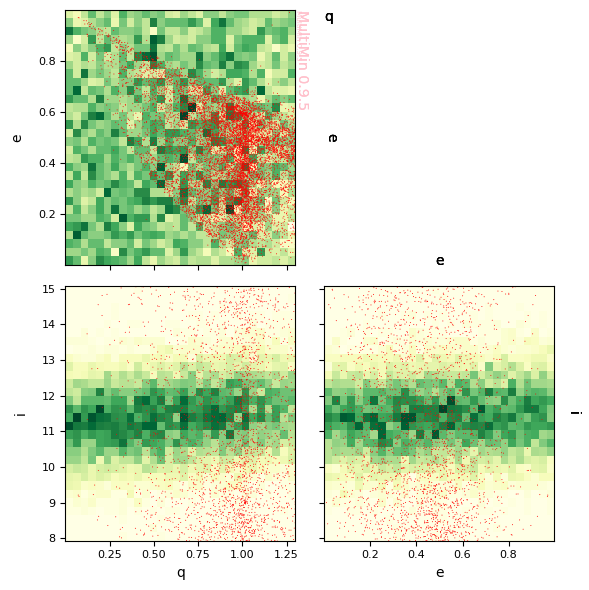

In [21]:
fit_qei = mn.FitCMND(ngauss=1, nvars=3, domain=[[0, 1.3], [0, 1.0], [0, 180]])
fit_qei.fit_data(data_neas_qei, advance=True, normalize=True)
print(f"-log(L)/N = {fit_qei.solution.fun/len(data_neas_qei)}")

properties=["q","e","i"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=fit_qei.plot_fit(
    properties=properties,
    hargs=hargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_1gauss_simple.png')

As you see, without information the fit is not too successful. We will try a different approach.

**Initial parameters from partial fits.** The 1-Gaussian fit in (q,e,i) often misses the q–e correlation when started from generic initial values. We use the three 2D fits (F_qe_1, F_qi_1, F_ei_1) to build initial means, sigmas, and correlations for the full 3D fit: each mean/sigma is averaged over the two partial fits that contain that variable; each correlation comes from the single partial fit that contains that pair.

Iterations:
Iter 0:
	Vars: [0.74, 0.43, 0.047, -3.9, -4, -5.2, -0.9, -0.016, -0.084]
	LogL/N: 673.7528857489652
Iter 1:
	Vars: [0.74, 0.43, 0.047, -3.9, -4, -5.2, -0.9, -0.016, -0.084]
	LogL/N: 673.7528855612924
Iter 2:
	Vars: [0.74, 0.43, 0.047, -3.9, -4, -5.2, -0.9, -0.016, -0.084]
	LogL/N: 673.7528856900369
-log(L)/N = -2.389519159674066


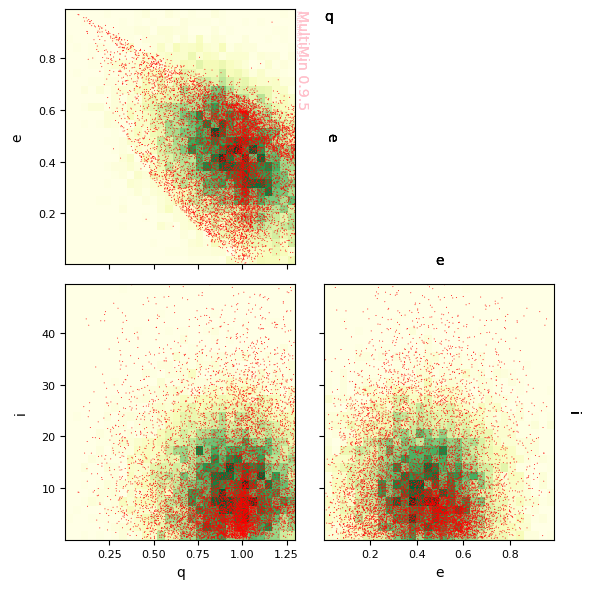

In [22]:
# Initial (mus, sigmas, rhos) from partial fits F_qe_1, F_qi_1, F_ei_1 (vars: 0=q, 1=e, 2=i)
mu_q = (F_qe_1.cmnd.mus[0, 0] + F_qi_1.cmnd.mus[0, 0]) / 2
mu_e = (F_qe_1.cmnd.mus[0, 1] + F_ei_1.cmnd.mus[0, 0]) / 2
mu_i = (F_qi_1.cmnd.mus[0, 1] + F_ei_1.cmnd.mus[0, 1]) / 2
sigma_q = (F_qe_1.cmnd.sigmas[0, 0] + F_qi_1.cmnd.sigmas[0, 0]) / 2
sigma_e = (F_qe_1.cmnd.sigmas[0, 1] + F_ei_1.cmnd.sigmas[0, 0]) / 2
sigma_i = (F_qi_1.cmnd.sigmas[0, 1] + F_ei_1.cmnd.sigmas[0, 1]) / 2
rho_qe = float(F_qe_1.cmnd.rhos[0, 0])
rho_qi = float(F_qi_1.cmnd.rhos[0, 0])
rho_ei = float(F_ei_1.cmnd.rhos[0, 0])

fit_qei = mn.FitCMND(ngauss=1, nvars=3, domain=[[0, 1.3], [0, 1.0], [0, 180]])
fit_qei.set_initial_params(
    mus=[mu_q, mu_e, mu_i],
    sigmas=[sigma_q, sigma_e, sigma_i],
    rhos=[rho_qe, rho_qi, rho_ei],
)
fit_qei.set_bounds(boundsm=((0.8, 1.2), (0.0, 1.0), (0.0, 15.0)))
fit_qei.fit_data(data_neas_qei, advance=True, normalize=True)
print(f"-log(L)/N = {fit_qei.solution.fun/len(data_neas_qei)}")

properties=["q","e","i"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=fit_qei.plot_fit(
    properties=properties,
    hargs=hargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_1gauss_feed.png')

Much better!

Let's try with more gaussians:

Iterations:
Iter 0:
	Vars: [-1.4, -1.4, -1.4, -1.4, -1.4, 0.96, 0.43, 8.4, 0.96, 0.43, 8.4, 0.96, 0.43, 8.4, 0.96, 0.43, 8.4, 0.96, 0.43, 8.4, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -0.9, -0.016, -0.084, -0.9, -0.016, -0.084, -0.9, -0.016, -0.084, -0.9, -0.016, -0.084, -0.9, -0.016, -0.084]
	LogL/N: 3.065803876720341


Iter 1:
	Vars: [-1.4, -1.4, -1.4, -1.4, -1.4, 0.96, 0.43, 8.4, 0.96, 0.43, 8.4, 0.96, 0.43, 8.4, 0.96, 0.43, 8.4, 0.96, 0.43, 8.4, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -0.9, -0.016, -0.084, -0.9, -0.016, -0.084, -0.9, -0.016, -0.084, -0.9, -0.016, -0.084, -0.9, -0.016, -0.084]
	LogL/N: 3.065803413080967
Iter 2:
	Vars: [-1.4, -1.4, -1.4, -1.4, -1.4, 0.96, 0.43, 8.4, 0.96, 0.43, 8.4, 0.96, 0.43, 8.4, 0.96, 0.43, 8.4, 0.96, 0.43, 8.4, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -3.6, -4, 4.6, -0.9, -0.016, -0.084, -0.9, -0.016, -0.084, -0.9, -0.016, -0.084, -0.9, -0.016, -0.084, -0.9, -0.016, -0.084]
	LogL/N: 3.0657989324839074


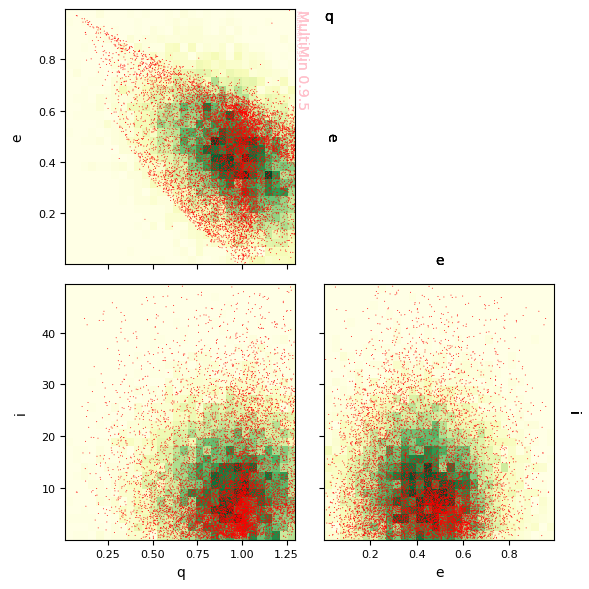

In [23]:
fit_qei = mn.FitCMND(ngauss=5, nvars=3, domain=[[0.0, 1.3], [0.0, 1.0], [0.0, 180.0]])

fit_qei.set_initial_params(
    mus=[mu_q, mu_e, mu_i],
    sigmas=[sigma_q, sigma_e, sigma_i],
    rhos=[rho_qe, rho_qi, rho_ei],
)

fit_qei.fit_data(data_neas_qei, advance=True)
G=fit_qei.plot_fit(
    properties=properties,
    hargs=hargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_ngauss.png')

The problem is that the fit is not converging to a good representation of the distribution.

### Transforming data

Orbital elements such as $q$, $e$, and $i$ live in **finite intervals** (e.g. $q \in [0, q_{\max}]$, $e \in [0, 1)$, $i \in [0, \pi]$), while the CMND is defined on the whole real line. To fit a normal mixture on unbounded variables we first map each bounded variable to an unbounded one via a **logistic-type (log-odds) transformation** (see e.g. the *manuscript-neoflux* formalism).

For a variable $x \in (0, x_{\max})$, define the **unbound** variable:

$$u = \log\left(\frac{x/x_{\max}}{1 - x/x_{\max}}\right)$$

so that $u \in (-\infty, +\infty)$. The inverse map is:

$$x = \frac{x_{\max}}{1 + \exp(-u)}$$

In the notebook we use this with $q_{\max}=1.35$ au, $e_{\max}=1$, $i_{\max}=\pi$ to obtain unbound variables $(Q, C, I)$. Fitting the CMND in $(Q, C, I)$ and then transforming back preserves normalization and often improves conditioning; the same transformation is used in the manuscript for the NEO flux formalism.

Transform variables to an unbounded scale for fitting (e.g. with `Util.t_if` / `f2u`):

In [24]:
scales=[1.35,1.00,180.0]
udata=np.zeros_like(data_neas_qei)
for i in range(len(data_neas_qei)):
    udata[i]=mn.Util.t_if(data_neas_qei[i],scales,mn.Util.f2u)

Visualize the data with **DensityPlot** (scatter on pairwise panels):

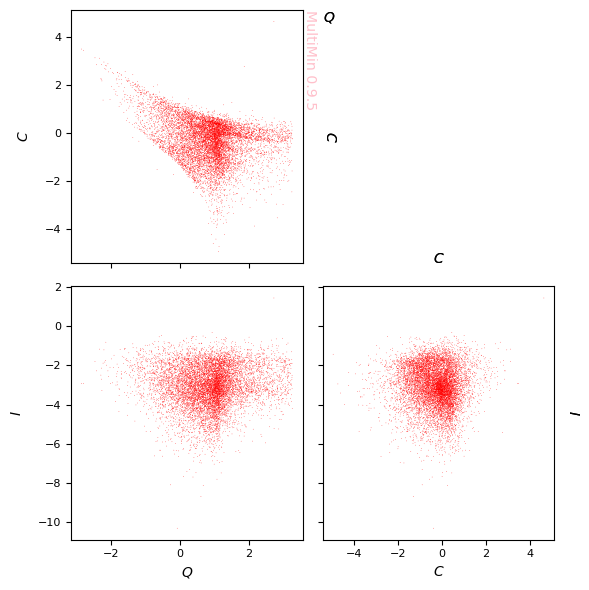

In [25]:
properties=dict(
    Q=dict(label=r"$Q$",range=None),
    E=dict(label=r"$C$",range=None),
    I=dict(label=r"$I$",range=None),
)
G=mn.DensityPlot(properties,figsize=3)

sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.scatter_plot(udata,**sargs)

plt.savefig('gallery/indepth_data_scatter_QCI.png')


The same idea (initial parameters from partial fits) can be reused for multi-component fits below.

You can also show 2D histograms on the panels:

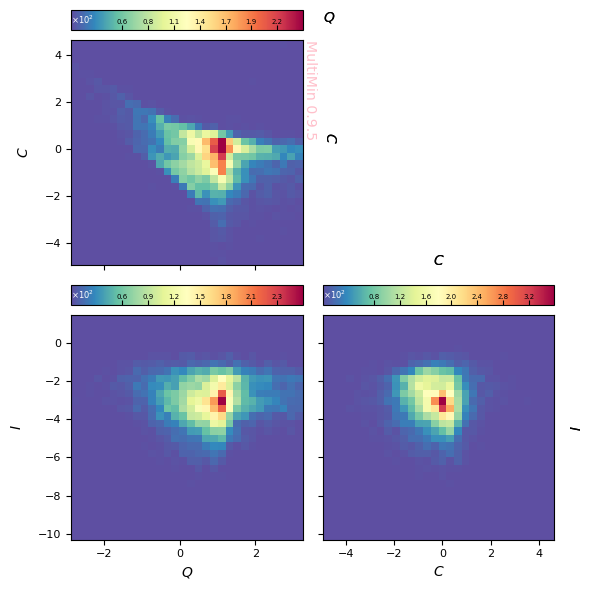

In [26]:
G=mn.DensityPlot(properties,figsize=3)
hargs=dict(bins=30,cmap='Spectral_r')
hist=G.plot_hist(udata,colorbar=True,**hargs)

plt.savefig('gallery/multimin_indepth_2.png')


Create the fitter (e.g. one Gaussian, three variables):

In [27]:
F=mn.FitCMND(ngauss=1,nvars=3)

The fitter holds an initial CMND that will be optimized:

In [28]:
print(F.cmnd)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.0, 0.0, 0.0]]
    Standard deviations (σ): [[1.0, 1.0, 1.0]]
    Correlation coefficients (ρ): [[0.0, 0.0, 0.0]]

    Covariant matrices (Σ): 
        [[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0]
        With std. and correlations (10):
            [p1,μ1_1,μ1_2,μ1_3,σ1_1,σ1_2,σ1_3,ρ1_12,ρ1_13,ρ1_23]
            [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]


Run the minimization:

In [29]:
t = mn.Util.el_time(0)
F.fit_data(udata,verbose=False,advance=1)
t = mn.Util.el_time()
print(f"-log(L)/N = {F.solution.fun/len(udata)}")

Iterations:
Iter 0:
	Vars: [2.3, 1.4, -2, -1.9, -1.6, -1.9, 1.4, 1.1, 1.1]
	LogL/N: 5.254073197500351
Iter 1:
	Vars: [1.7, 0.53, -2.5, -1.8, -1.8, -1.9, 1.1, 1.1, 0.84]
	LogL/N: 4.7170476345350085
Iter 2:
	Vars: [0.8, -0.37, -3.1, -2.2, -2.2, -2, -0.028, 0.27, 0.54]
	LogL/N: 4.092003838350309
Iter 3:
	Vars: [0.86, -0.34, -3, -2.4, -2.4, -2.1, -0.63, 0.067, -0.037]
	LogL/N: 3.949132082333882
Iter 4:
	Vars: [0.85, -0.33, -3.1, -2.4, -2.4, -2.1, -0.65, 0.084, -0.1]
	LogL/N: 3.947787793004998
Iter 5:
	Vars: [0.85, -0.32, -3.1, -2.4, -2.4, -2.1, -0.65, 0.084, -0.11]
	LogL/N: 3.9475649453365413
Iter 6:
	Vars: [0.85, -0.32, -3.1, -2.4, -2.4, -2.1, -0.65, 0.084, -0.11]
	LogL/N: 3.9475649453365413
Elapsed time since last call: 146.378 ms
-log(L)/N = 3.9475649453365413


Inspect the fitted CMND:

In [30]:
print(F.cmnd)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.8467316592430071, -0.32435102971128116, -3.0555845304423435]]
    Standard deviations (σ): [[0.8494598343947701, 0.8656234933684983, 1.0544372554456933]]
    Correlation coefficients (ρ): [[-0.31494039824975584, 0.04219145680611591, -0.05330743136720484]]

    Covariant matrices (Σ): 
        [[[0.7215820102499902, -0.2315795767320035, 0.0377909763110104], [-0.2315795767320035, 0.7493040322714827, -0.04865612665797756], [0.0377909763110104, -0.04865612665797756, 1.1118379256718462]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.8467316592430071, -0.32435102971128116, -3.0555845304423435, 0.7215820102499902, -0.2315795767320035, 0.0377909763110104, 0.7493040322714827, -0.04865612665797756, 1.1118379256718462]
        With std. and correla

Plot the fit result (fitted sample + data scatter):

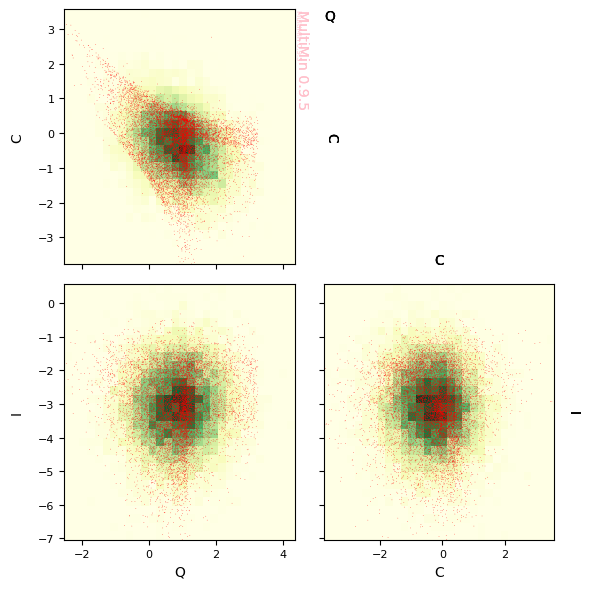

In [31]:
properties=["Q","C","I"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.2,edgecolor='None',color='r')
G=F.plot_fit(properties=properties,hargs=hargs,sargs=sargs,figsize=3)

plt.savefig(f'gallery/{figprefix}_indepth_fit_result_QCI.png')


Fitting can be time-consuming; you can save the result for later use:

In [32]:
F.save_fit(f"gallery/{figprefix}_fit-single.pkl",useprefix=False)

Load a previously saved fit (here or in another notebook):

In [33]:
F=mn.FitCMND(f"gallery/{figprefix}_fit-single.pkl")
print(F.cmnd)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.8467316592430071, -0.32435102971128116, -3.0555845304423435]]
    Standard deviations (σ): [[0.8494598343947701, 0.8656234933684983, 1.0544372554456933]]
    Correlation coefficients (ρ): [[-0.31494039824975584, 0.04219145680611591, -0.05330743136720484]]

    Covariant matrices (Σ): 
        [[[0.7215820102499902, -0.2315795767320035, 0.0377909763110104], [-0.2315795767320035, 0.7493040322714827, -0.04865612665797756], [0.0377909763110104, -0.04865612665797756, 1.1118379256718462]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.8467316592430071, -0.32435102971128116, -3.0555845304423435, 0.7215820102499902, -0.2315795767320035, 0.0377909763110104, 0.7493040322714827, -0.04865612665797756, 1.1118379256718462]
        With std. and correla

Fit with two Gaussian components for a better likelihood:

Iterations:
Iter 0:
	Vars: [0, 0, 2.7, 1.4, -2.1, 1.8, 0.54, -2.3, -1.2, -1.4, -1.6, -2.1, -2.1, -2, 1.5, 1.2, 1.2, 1.4, 1.3, 0.9]
	LogL/N: 4.9321683435996935


Iter 5:
	Vars: [-1.2, -0.003, 0.31, 0.29, -3.1, 1.1, -0.59, -3.1, -2.4, -2.7, -2.2, -2.5, -2.4, -2.1, -1.6, -0.57, 0.1, 0.12, 0.4, -0.19]
	LogL/N: 3.8705379598427054


Iter 9:
	Vars: [-1.3, -0.0029, 0.56, 0.45, -3.4, 0.95, -0.62, -2.9, -2.3, -2.8, -2.1, -2.5, -2.5, -2.2, -2.3, -0.46, 0.56, -0.11, 0.27, 0.0098]
	LogL/N: 3.855886877863522
Elapsed time since last call: 855.557 ms
-log(L)/N = 3.855886877863522
Composition of ngauss = 2 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.29264516227672854, 0.7073548377232713]
    Number of variables: 3
    Averages (μ): [[0.5600089832172639, 0.4470817693931252, -3.385768938965438], [0.9450701881630373, -0.624275547481636, -2.9241937381061085]]
    Standard deviations (σ): [[0.9368256350360942, 0.5587930681599639, 1.125017958655174], [0.7871548838660488, 0.7724371959178873, 0.9901655616025229]]
    Correlation coefficients (ρ): [[-0.8199123051631576, -0.22693889213237106, 0.2711037191672738], [-0.05517710409508136, 0.1338534987561768, 0.004898151070124701]]

    Covariant matrices (Σ): 
        [[[0.8776422704607811, -0.42921726264816423, -0.2391812612524247], [-0.42921726264816423, 0.312

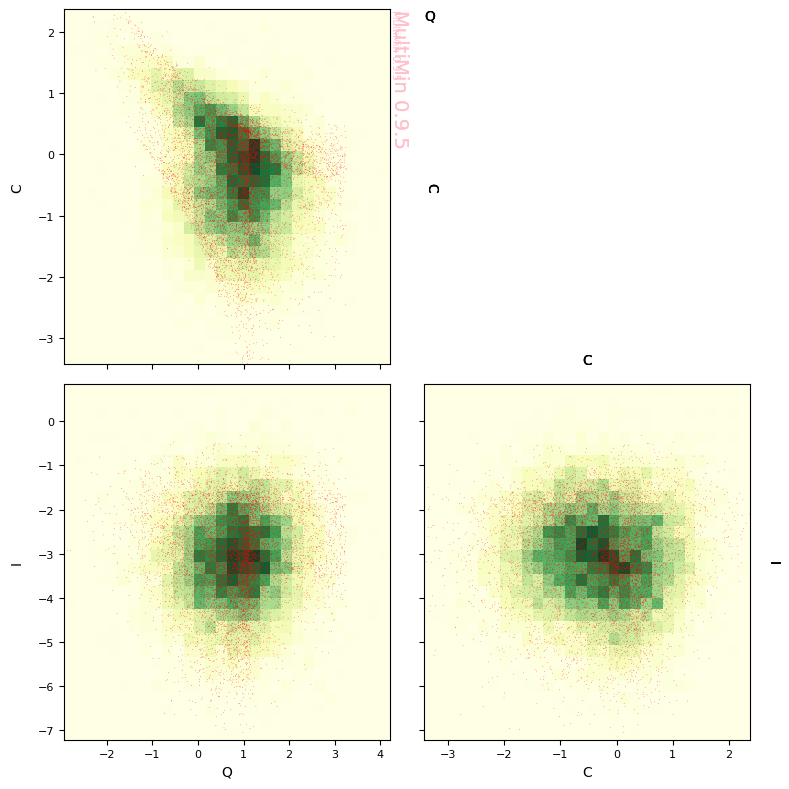

In [34]:
F=mn.FitCMND(ngauss=2,nvars=3)

mn.Util.el_time(0)
F.fit_data(udata,advance=5)
mn.Util.el_time()
F.save_fit(f"gallery/{figprefix}_fit-multiple.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.cmnd)

G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            hargs=dict(bins=30,cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'))
F.fig.savefig(f"gallery/{figprefix}_fit-multiple-{F.prefix}.png")

Using two components improves the fit (lower $-\log\mathcal{L}/N$).

You can set bounds on parameters (e.g. means, weights) to avoid unphysical solutions:

Iterations:
Iter 0:
	Vars: [2.2, 2.2, 2.7, 1.4, -2.1, 1.8, 0.53, -2.3, -1.2, -1.4, -1.6, -2.1, -2.1, -2, 1.5, 1.2, 1.2, 1.4, 1.3, 0.9]
	LogL/N: 4.933040496089534


Iter 5:
	Vars: [-0.35, 2.2, 0.31, 0.28, -3.1, 1.1, -0.59, -3.1, -2.4, -2.7, -2.2, -2.5, -2.4, -2.1, -1.6, -0.56, 0.094, 0.11, 0.41, -0.2]
	LogL/N: 3.8707123153165544


Iter 10:
	Vars: [-0.52, 2.2, 0.58, 0.45, -3.4, 0.93, -0.62, -2.9, -2.2, -2.8, -2.1, -2.5, -2.5, -2.2, -2.3, -0.45, 0.57, -0.14, 0.27, 0.011]
	LogL/N: 3.8556259836727476
Elapsed time since last call: 1.04185 s
-log(L)/N = 3.8556259836727476
Composition of ngauss = 2 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.29249018447009795, 0.707509815529902]
    Number of variables: 3
    Averages (μ): [[0.5821041773175402, 0.4464743474461652, -3.3911379022736123], [0.9348902498027679, -0.6243202696750589, -2.922011349921984]]
    Standard deviations (σ): [[0.9596656359472125, 0.5601029523762859, 1.1249887938830723], [0.781435244237796, 0.7733774937834712, 0.9908327438672471]]
    Correlation coefficients (ρ): [[-0.8243627844677568, -0.21943640640473838, 0.27599616860850507], [-0.06777308490528855, 0.13595710635891156, 0.005329661122647211]]

    Covariant matrices (Σ): 
        [[[0.9209581328179679, -0.44310452297794645, -0.23690641596855505], [-0.44310452297794645, 0.31

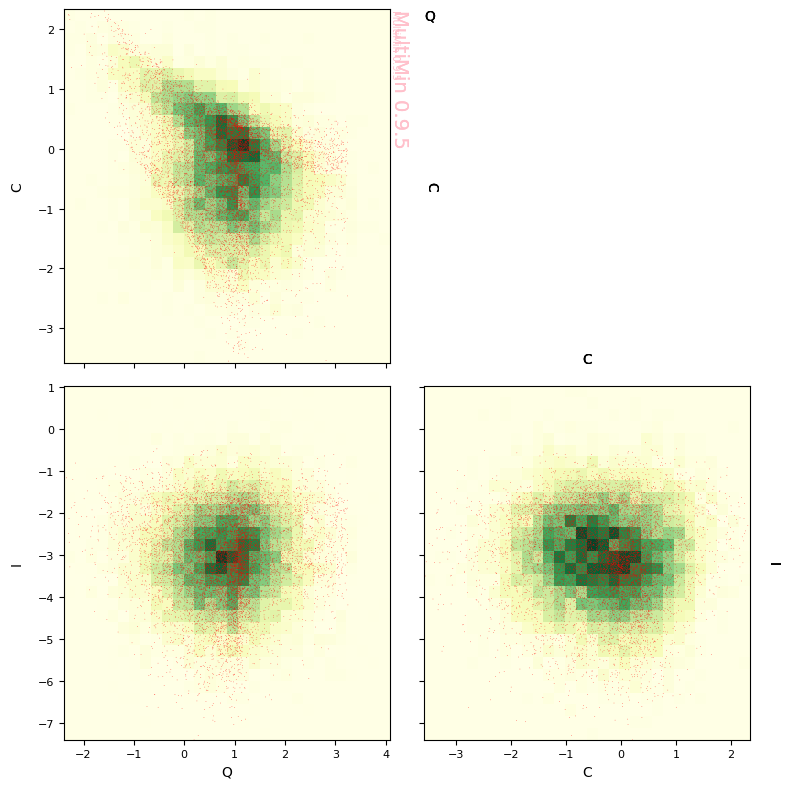

In [35]:
F=mn.FitCMND(ngauss=2,nvars=3)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(udata,advance=5,bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/{figprefix}_fit-multiple-bounds.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.cmnd)
G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            hargs=dict(bins=30,cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'))
F.fig.savefig("gallery/indepth_fit_2gauss_bounds_QCI.png")

Fitting with five Gaussians can capture more structure:

Iterations:
Iter 0:
	Vars: [2.2, 2.2, 2.2, 2.2, 2.2, 2.8, 1.5, -2.2, 2.6, -0.016, -2.2, 1.9, 0.34, -2.9, 1.7, 0.31, -2.2, 0.24, 2.2, -2.1, -1.3, -1.2, -1.4, -1.4, -2.2, -2.4, -2.1, -3.1, -2, -2.3, -2, -2.1, -2.3, -1.2, -2.1, 2.3, 1.9, 1.3, 2.2, 1.3, 0.83, 0.43, 1.5, 1, 1.4, 1.3, 1.1, 0.48, 0.47, 1.2]
	LogL/N: 4.7180111328822445


Iter 10:
	Vars: [-1.6, 1.2, 0.096, -0.67, -0.27, 1.3, -1.2, -3.9, 0.95, -0.66, -2.8, 0.84, 0.38, -3.4, 1.5, -0.08, -3.3, -0.18, -0.27, -2.6, -2.4, -2.3, -1.7, -3.1, -2.7, -2.4, -2.6, -3.3, -2.1, -2.3, -3.5, -2.4, -2.6, -2, -2.4, -0.41, 1.7, -0.58, -0.46, 0.61, -0.18, -2.2, 0.21, 0.058, -0.057, 0.99, 0.6, -2.5, -0.093, 0.3]
	LogL/N: 3.7085742751695028


Iter 18:
	Vars: [-0.94, 0.51, -0.75, -0.31, 0.16, 1.4, -0.82, -3.5, 0.99, -0.57, -2.8, 0.66, 0.51, -3.6, 1.4, 0.094, -3.2, 0.013, -0.54, -2.7, -2.4, -2.5, -1.8, -3.4, -2.8, -2.3, -2.6, -3.2, -2, -2.4, -3.6, -2.4, -2.6, -2, -2.4, -0.3, 1.6, -0.19, -0.72, 0.54, -0.43, -2.6, -0.11, 0.29, -0.9, 0.55, 0.37, -2.5, -0.26, 0.47]
	LogL/N: 3.6926282412738534
Elapsed time since last call: 9.87629 s
-log(L)/N = 3.6926282412738534
Composition of ngauss = 5 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.1284524457337132, 0.28530130585212693, 0.14646571727922708, 0.1931584852090802, 0.24662204592585263]
    Number of variables: 3
    Averages (μ): [[1.4044038488264357, -0.8180063257340894, -3.5374249762542793], [0.9885674672659737, -0.5679915465855964, -2.839475749467145], [0.6564443085116567, 0.5053417330386183, -3.5871083673870223], [1.4034281291741006, 0.09445634105435385, -3.151303734598917], [0.012771654381390296, -0.5447298948014303, -2.671441592098541]]
    Standard devi

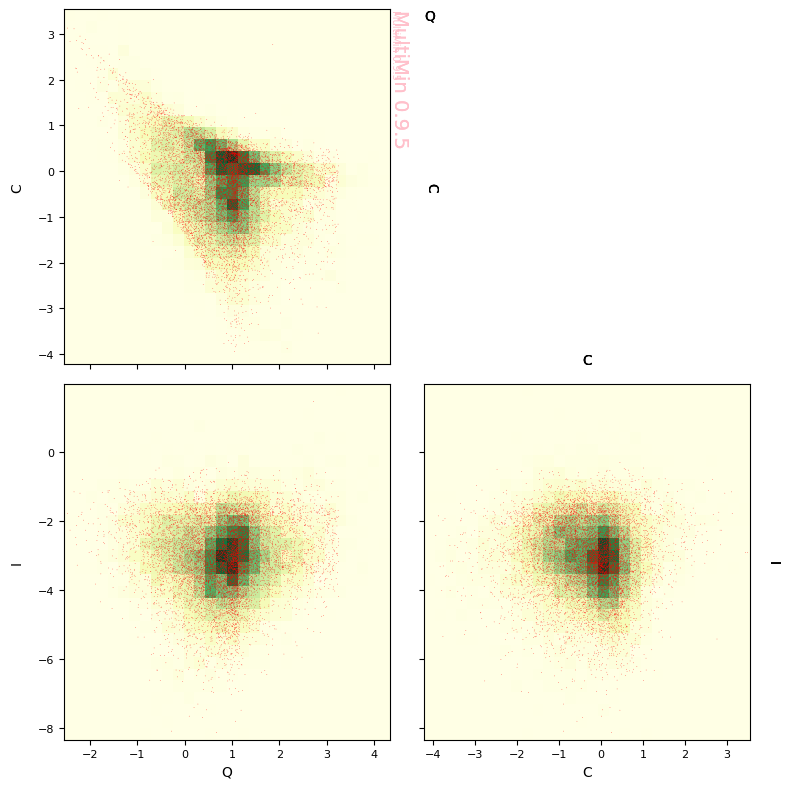

In [36]:
F=mn.FitCMND(ngauss=5,nvars=3)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(udata,advance=10,bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/fit-multiple-bound_mus.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.cmnd)
G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            hargs=dict(bins=30,cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'))
F.fig.savefig(f"gallery/{figprefix}_fit_5gauss_bound_mus_QCI.png")

As you can see the fitting parameter $-\log{\cal L}$ is improved with respect to previous fit. 

Verify the fit by generating a sample from the fitted CMND and comparing to the data:

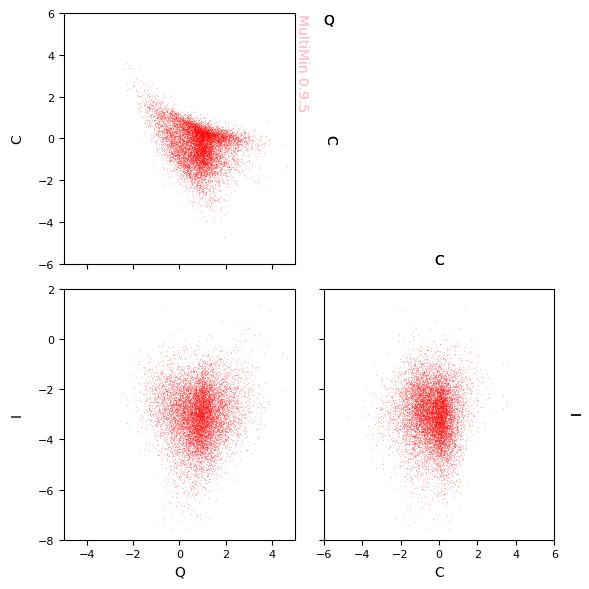

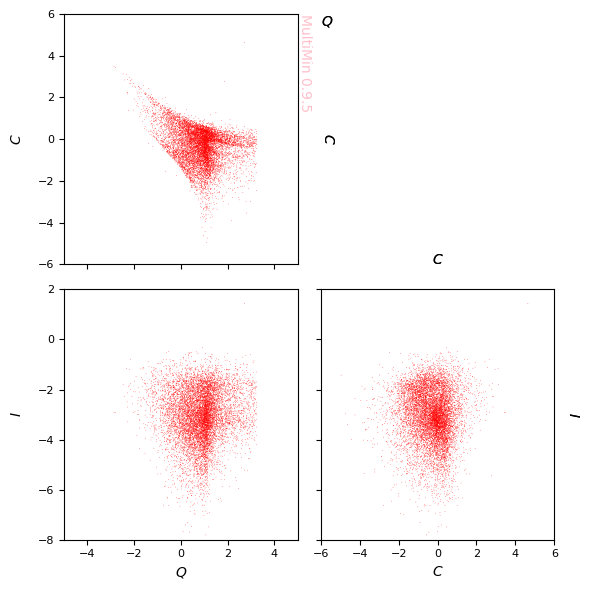

In [37]:
F.cmnd.plot_sample(N=len(F.data),
                  figsize=3,
                  properties=["Q","C","I"],ranges=[[-5,5],[-6,6],[-8,2]],
                  sargs=dict(s=0.2,edgecolor='None',color='r'))
G.fig.savefig(f"gallery/{figprefix}_sample_from_fit_20gauss_QCI.png")

properties=dict(
    Q=dict(label=r"$Q$",range=[-5,5]),
    C=dict(label=r"$C$",range=[-6,6]),
    I=dict(label=r"$I$",range=[-8,2]),
)
G=mn.DensityPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.scatter_plot(udata,**sargs)

We can also check the original distribution:

In [38]:
scales=[1.35,1.00,180.0]
usample = F.cmnd.rvs(len(udata))
rsample=np.zeros_like(usample)
for i in range(len(usample)):
    rsample[i] = mn.Util.t_if(usample[i], scales, mn.Util.u2f)

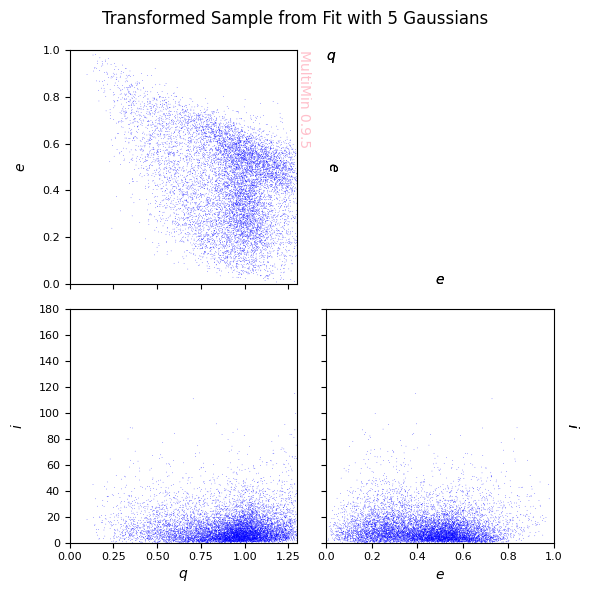

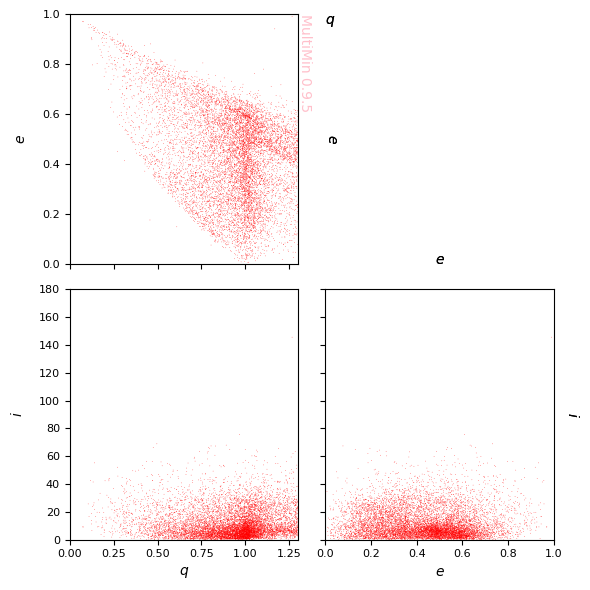

In [39]:
properties=dict(
    q=dict(label=r"$q$", range=[0.0, 1.3]),
    e=dict(label=r"$e$", range=[0.0, 1.0]),
    i=dict(label=r"$i$", range=[0.0, 180.0]),
)

Gt=mn.DensityPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='b')
scatter_transformed=Gt.scatter_plot(rsample,**sargs)
Gt.fig.suptitle(f"Transformed Sample from Fit with {F.ngauss} Gaussians")
Gt.fig.tight_layout()
Gt.fig.savefig(f"gallery/{figprefix}_sample_from_fit_ngauss_qei.png")

Go=mn.DensityPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
scatter_original=Go.scatter_plot(data_neas_qei,**sargs)

In [40]:
function, cmnd = F.cmnd.get_function(properties=properties)

from multimin import nmd

def cmnd(X):

    mu1_q = 1.404404
    mu1_e = -0.818006
    mu1_i = -3.537425
    mu1 = [mu1_q, mu1_e, mu1_i]
    Sigma1 = [[0.653854, -0.089572, 0.777116], [-0.089572, 0.537819, -0.096935], [0.777116, -0.096935, 2.043543]]
    n1 = nmd(X, mu1, Sigma1)

    mu2_q = 0.988567
    mu2_e = -0.567992
    mu2_i = -2.839476
    mu2 = [mu2_q, mu2_e, mu2_i]
    Sigma2 = [[0.11253, -0.067324, 0.077331], [-0.067324, 0.333825, -0.106557], [0.077331, -0.106557, 0.760007]]
    n2 = nmd(X, mu2, Sigma2)

    mu3_q = 0.656444
    mu3_e = 0.505342
    mu3_i = -3.587108
    mu3 = [mu3_q, mu3_e, mu3_i]
    Sigma3 = [[0.441556, -0.219751, -0.040392], [-0.219751, 0.145741, 0.063567], [-0.040392, 0.063567, 1.309736]]
    n3 = nmd(X, mu3, Sigma3)

    mu4_q = 1.403428
    mu4_e = 0.094456
    mu4_i = -3.151304
    mu4 = [mu4_q, mu4_e, mu4_i]
    Sigma4 = [[0.733313, -0.094824, 0.188734], [-0.094824, 0.068869, 0.039075], [0.188734, 0.039075, 0.66863]]
    n4 = nmd(X, mu4, Sigma4)

  

---

**MultiMin** - Multivariate Gaussian fitting

© 2026 Jorge I. Zuluaga